# purpose
- 事業×デバイス別に、時系列データから次営業日の売上額を予測するモデルを作成すること


# TODOs
- 売上・曜日のデータ作成
- モデルに読み込ませる時系列データ（7:1）作成
- 学習データをLSTMに読み込ませて学習
- LSTMの性能評価
- 次営業日の売上額を予測

### 事業×デバイス別のデータ作成

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
df = pd.read_csv('train_data.csv').sort_values('dt')

In [4]:
df.head()

,dt,holiday_flg,day_of_week,biz_category,category,uu,nontax_amount,arppu
0,2017-02-05,False,7,電子書籍,03.sp_only,15909,17090209,1074
1,2017-02-05,False,7,ゲーム,02.pc_only,39492,90984293,2303
2,2017-02-05,False,7,ライブコミュニケーション,02.pc_only,6337,23072880,3640
3,2017-05-17,False,3,電子書籍,01.multi_device,87,188050,2161
4,2017-05-19,False,5,同人,03.sp_only,15364,7302570,475


In [5]:
# 事業部別にデータを分割するためのリストを作成
biz_category_list = list(set(df['biz_category']))
print(biz_category_list)
data_list_tmp = [df[df['biz_category'] == biz_category] for biz_category in biz_category_list]

['電子書籍', '動画', 'その他', 'ライブコミュニケーション', '同人', 'ゲーム']


In [6]:
# デバイス別にデータを分割するためのリストを作成
device_category_list = list(set(df['category']))
print(device_category_list)

data_list = []
for device_category in device_category_list:
    for data in data_list_tmp:
        data_list.append(data[data['category'] == device_category].loc[:, ['dt', 'nontax_amount', 'day_of_week']])

data_list[0].tail()

['01.multi_device', '03.sp_only', '02.pc_only']


,dt,nontax_amount,day_of_week
18527,2018-09-30,419916,7
18543,2018-11-11,291170,7
18556,2018-12-02,399063,7
18573,2019-03-21,338830,4
18582,2019-05-19,354641,7


In [7]:
# 学習データ可視化する関数
def plot_sales(
    x, y, 
    category_list, data_list,
    num_biz_cotegory, num_device_category, line_width):

    ax_list = []

    for i in range(len(category_list)):
        ax_list.append(
            {
                'ax':fig.add_subplot(num_biz_cotegory, num_device_category, i + 1),
                'category':category_list[i],
                 'data':data_list[i]
                 }
            )

    for ax in ax_list:
        ax['ax'].tick_params(labelbottom='off')
        ax['ax'].set_title(ax['category'])
        ax['ax'].plot(x, y, data=ax['data'], linewidth=line_width)

In [8]:
category_list = []
for device_category in device_category_list:
    for biz_category in biz_category_list:
        category_list.append(biz_category + '_' + device_category)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


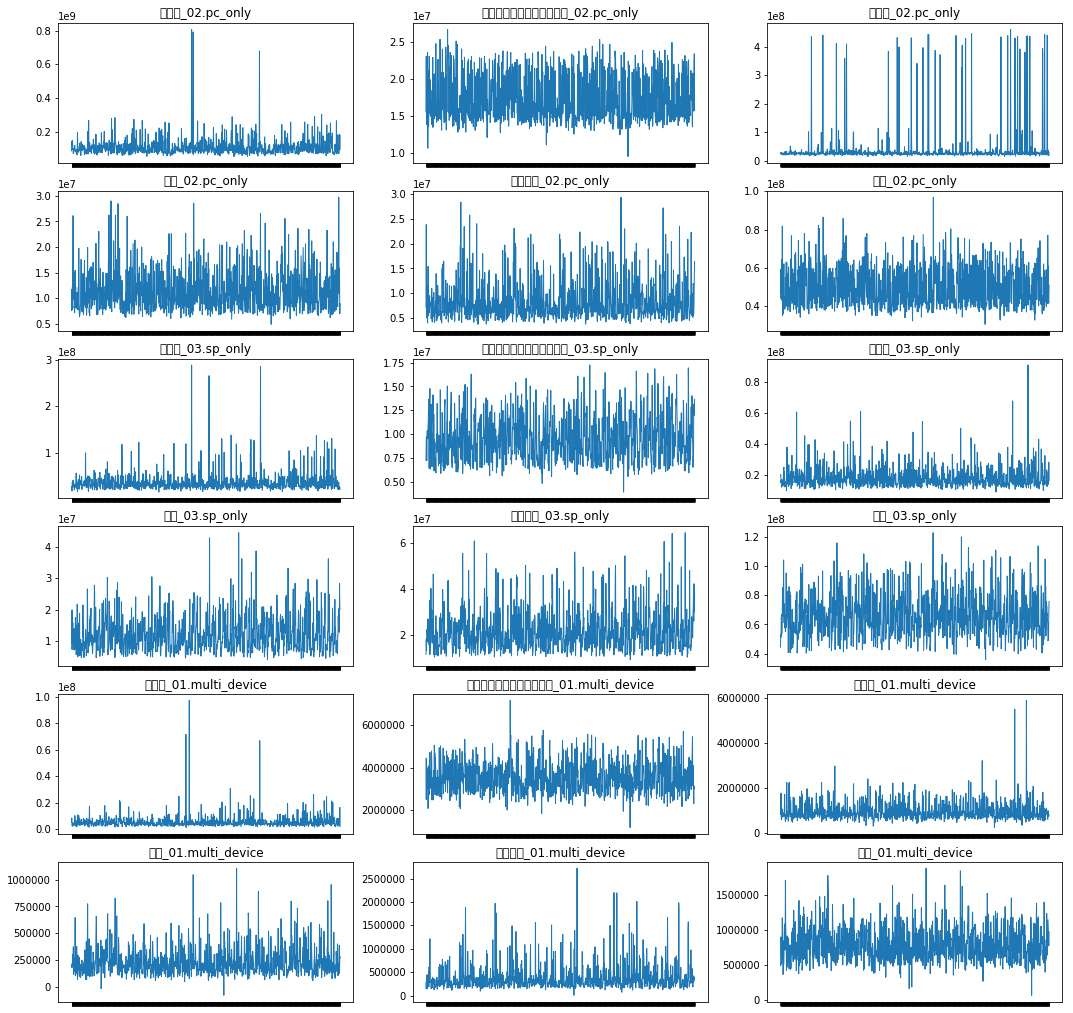

In [11]:
# 学習データ可視化
fig = plt.figure(figsize=(18, 18))

plot_sales('dt', 'nontax_amount', category_list, data_list, 6, 3, 1)

### モデルに読み込ませる時系列データ作成

In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

np.random.seed(7)

In [10]:
# 入力に用いる変数のリストを作る
input_list = []

for device_category in device_category_list:
    for data in data_list_tmp:
        input_list.append(data[data['category'] == device_category].loc[:, ['nontax_amount', 'day_of_week']]) #.astype('float32')

In [11]:
input_df_list = []
for i in range(len(input_list)):
    input_df_list.append(pd.DataFrame(input_list[i]))
input_df_list[0].head()

,nontax_amount,day_of_week
3,188050,3
21,610119,6
32,366350,4
39,291686,5
42,1212163,7


In [12]:
# 前処理データを格納するリストを作成
scaler_list = []        
scaled_dataset_list = []

scaler = MinMaxScaler(feature_range=(0, 1))  # データを0~1に変換
for data in input_df_list:
    # データの前処理
    data = scaler.fit_transform(data)
    # 前処理したデータを格納
    scaler_list.append(scaler.fit(data.reshape(-1, 2)))
    scaled_dataset_list.append(scaler.transform(data.reshape(-1, 2)))
    
scaled_dataset_list[0]

array([[0.06722627, 0.33333333],
       [0.2224653 , 0.83333333],
       [0.13280588, 0.5       ],
       ...,
       [0.14483788, 1.        ],
       [0.12268389, 0.5       ],
       [0.12849925, 1.        ]])

In [13]:
# データ整形関数
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    names = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(input_df_list[1].columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(input_df_list[1].columns[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(input_df_list[1].columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [14]:
# データ整形
LENGTH_PER_UNIT = 7
reframed_dataset_list =  [series_to_supervised(scaled_dataset, LENGTH_PER_UNIT, 1) for scaled_dataset in scaled_dataset_list]

# 予測したくないデータの削除
DELETE_COLUMN = LENGTH_PER_UNIT*2 +1
reframed_list = []
for dataset in reframed_dataset_list:
    reframed_list.append(dataset.drop(dataset.columns[[DELETE_COLUMN]], axis=1))
reframed_list[0].head()

,nontax_amount(t-7),day_of_week(t-7),nontax_amount(t-6),day_of_week(t-6),nontax_amount(t-5),day_of_week(t-5),nontax_amount(t-4),day_of_week(t-4),nontax_amount(t-3),day_of_week(t-3),nontax_amount(t-2),day_of_week(t-2),nontax_amount(t-1),day_of_week(t-1),nontax_amount(t)
7,0.067226,0.333333,0.222465,0.833333,0.132806,0.500000,0.105344,0.666667,0.443900,1.000000,0.102693,1.000000,0.100457,0.500000,0.109105
8,0.222465,0.833333,0.132806,0.500000,0.105344,0.666667,0.443900,1.000000,0.102693,1.000000,0.100457,0.500000,0.109105,0.500000,0.051015
9,0.132806,0.500000,0.105344,0.666667,0.443900,1.000000,0.102693,1.000000,0.100457,0.500000,0.109105,0.500000,0.051015,0.666667,0.084533
10,0.105344,0.666667,0.443900,1.000000,0.102693,1.000000,0.100457,0.500000,0.109105,0.500000,0.051015,0.666667,0.084533,0.833333,0.157957
11,0.443900,1.000000,0.102693,1.000000,0.100457,0.500000,0.109105,0.500000,0.051015,0.666667,0.084533,0.833333,0.157957,0.666667,0.141984


In [18]:
# データをtrainとtestに分ける
values_list = [data.values for data in reframed_list]

train_size = int(len(values_list[0]) * 0.67)  
test_size = len(values_list[0]) - train_size 

train_adjast_num = train_size%LENGTH_PER_UNIT
test_adjast_num = test_size%LENGTH_PER_UNIT

# train/testを分ける
train_list = [data[train_adjast_num:train_size,:] for data in values_list]
test_list = [data[train_size:len(data)-test_adjast_num,:] for data in values_list]

In [33]:
print(f'train_list: {np.array(train_list).shape}')
print(f'test_list: {np.array(test_list).shape}')

train_list: (18, 686, 15)
test_list: (18, 336, 15)


In [20]:
# input と　outputに分ける
train_x_list = [train_data[:, :-1] for train_data in train_list]
train_y_list = [train_data[:, -1] for train_data in train_list]
test_x_list = [test_data[:, :-1] for test_data in test_list]
test_y_list = [test_data[:, -1] for test_data in test_list]

In [21]:
# inputデータを 3D [samples, timesteps, features]に変形

train_x_list = [train_x.reshape((train_x.shape[0], LENGTH_PER_UNIT, 2)) for train_x in train_x_list]
test_x_list = [test_x.reshape((test_x.shape[0], LENGTH_PER_UNIT, 2)) for test_x in test_x_list]

print(train_x_list[0].shape, train_y_list[0].shape, test_x_list[0].shape, test_y_list[0].shape)

(686, 7, 2) (686,) (336, 7, 2) (336,)


### 学習データをLSTMに読み込ませて学習

In [22]:
# LSTMの定義とfit
#!pip install --upgrade pip tensorboard
import math
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras import optimizers

# 最適化手法の設定
opt = optimizers.Adam()
def build_model(x_train, y_train, x_test, y_test): 
    model = Sequential()
    # 隠れ層、LSTMに入力するデータの形を指定([バッチサイズ，step数，特徴の次元数]を指定する）
    model.add(LSTM(100, input_shape=(test_x_list[0].shape[1], train_x_list[0].shape[2])))
    model.add(Dense(1))
    model.add(Activation("linear"))
    # モデルのコンパイル
    model.compile(optimizer = opt,  # 最適化手法
                  loss = 'mean_squared_error',  # 損失関数
                  metrics = ['accuracy'])   # 評価関数
    
    model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), verbose=1)
    
    return model

model_list = []

for i in range(len(category_list)):
    print(i)
    print(category_list[i])
    model_list.append(build_model(train_x_list[i], train_y_list[i], test_x_list[i], test_y_list[i]))
    print('')

Using TensorFlow backend.



0
ゲーム_02.pc_only




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 686 samples, validate on 336 samples
Epoch 1/50





686/686 [==============================] - 7s 11ms/step - loss: 0.0056 - acc: 0.0015 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 2/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0053 - acc: 0.0015 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 3/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0052 - acc: 0.0015 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 4/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0054 - acc: 0.0015 - val_loss: 0.0050 - val_acc: 0.0000e+00
Epoch 5/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0053 - acc: 0.0015 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 6/50
686/686 [==============================] - 5s 7ms/step - loss: 0.0052 - acc: 0.0015 - val_loss: 0.0048 - val_acc: 0.0000e+00
Epoch 7/50
68

Epoch 46/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0347 - acc: 0.0000e+00 - val_loss: 0.0315 - val_acc: 0.0030
Epoch 47/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0342 - acc: 0.0000e+00 - val_loss: 0.0320 - val_acc: 0.0030
Epoch 48/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0346 - acc: 0.0015 - val_loss: 0.0331 - val_acc: 0.0030
Epoch 49/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0345 - acc: 0.0015 - val_loss: 0.0315 - val_acc: 0.0030
Epoch 50/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0342 - acc: 0.0015 - val_loss: 0.0319 - val_acc: 0.0030

2
その他_02.pc_only
Train on 686 samples, validate on 336 samples
Epoch 1/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0181 - acc: 0.0015 - val_loss: 0.0404 - val_acc: 0.0000e+00
Epoch 2/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0176 - acc: 0.0015 - val_loss: 0.0406 - val_acc: 0

686/686 [==============================] - 3s 4ms/step - loss: 0.0245 - acc: 0.0000e+00 - val_loss: 0.0250 - val_acc: 0.0030
Epoch 6/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0245 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0030
Epoch 7/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0243 - acc: 0.0000e+00 - val_loss: 0.0253 - val_acc: 0.0030
Epoch 8/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0243 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0030
Epoch 9/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0244 - acc: 0.0000e+00 - val_loss: 0.0250 - val_acc: 0.0030
Epoch 10/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0244 - acc: 0.0000e+00 - val_loss: 0.0254 - val_acc: 0.0030
Epoch 11/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0246 - acc: 0.0000e+00 - val_loss: 0.0250 - val_acc: 0.0030
Epoch 12/50
686/686 [==============================] - 3s

686/686 [==============================] - 4s 6ms/step - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.0238 - val_acc: 0.0030
Epoch 24/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0260 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0030
Epoch 25/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0258 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0030
Epoch 26/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0259 - acc: 0.0000e+00 - val_loss: 0.0235 - val_acc: 0.0030
Epoch 27/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0257 - acc: 0.0000e+00 - val_loss: 0.0239 - val_acc: 0.0030
Epoch 28/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0258 - acc: 0.0000e+00 - val_loss: 0.0240 - val_acc: 0.0030
Epoch 29/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0260 - acc: 0.0000e+00 - val_loss: 0.0235 - val_acc: 0.0030
Epoch 30/50
686/686 [==============================] 

686/686 [==============================] - 4s 5ms/step - loss: 0.0265 - acc: 0.0015 - val_loss: 0.0327 - val_acc: 0.0030
Epoch 42/50
686/686 [==============================] - 4s 5ms/step - loss: 0.0263 - acc: 0.0015 - val_loss: 0.0329 - val_acc: 0.0030
Epoch 43/50
686/686 [==============================] - 4s 5ms/step - loss: 0.0262 - acc: 0.0015 - val_loss: 0.0322 - val_acc: 0.0030
Epoch 44/50
686/686 [==============================] - 4s 5ms/step - loss: 0.0267 - acc: 0.0015 - val_loss: 0.0318 - val_acc: 0.0030
Epoch 45/50
686/686 [==============================] - 4s 5ms/step - loss: 0.0264 - acc: 0.0015 - val_loss: 0.0323 - val_acc: 0.0030
Epoch 46/50
686/686 [==============================] - 4s 5ms/step - loss: 0.0262 - acc: 0.0015 - val_loss: 0.0322 - val_acc: 0.0030
Epoch 47/50
686/686 [==============================] - 4s 5ms/step - loss: 0.0261 - acc: 0.0000e+00 - val_loss: 0.0333 - val_acc: 0.0030
Epoch 48/50
686/686 [==============================] - 4s 5ms/step - loss: 0.

686/686 [==============================] - 3s 5ms/step - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.0262 - val_acc: 0.0030
Epoch 10/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0223 - acc: 0.0000e+00 - val_loss: 0.0258 - val_acc: 0.0030
Epoch 11/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0223 - acc: 0.0000e+00 - val_loss: 0.0260 - val_acc: 0.0030
Epoch 12/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0219 - acc: 0.0000e+00 - val_loss: 0.0263 - val_acc: 0.0030
Epoch 13/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0222 - acc: 0.0000e+00 - val_loss: 0.0260 - val_acc: 0.0030
Epoch 14/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0222 - acc: 0.0000e+00 - val_loss: 0.0270 - val_acc: 0.0030
Epoch 15/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0222 - acc: 0.0000e+00 - val_loss: 0.0259 - val_acc: 0.0030
Epoch 16/50
686/686 [==============================] 

686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 28/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 29/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 30/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 31/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 32/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 33/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 34/50
686/686 [==============================] 

686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0030
Epoch 46/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0030
Epoch 47/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0030
Epoch 48/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0042 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0030
Epoch 49/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0084 - val_acc: 0.0030
Epoch 50/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0085 - val_acc: 0.0030

15
同人_01.multi_device
Train on 686 samples, validate on 336 samples
Epoch 1/50
686/686 [==============================] - 10s 14ms/step - loss: 0.0146 - acc: 0.0015 - val_loss: 0.0140 - val

Epoch 4/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0096 - acc: 0.0015 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 5/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0096 - acc: 0.0015 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 6/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0095 - acc: 0.0015 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 7/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0095 - acc: 0.0015 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 8/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0094 - acc: 0.0015 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 9/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0095 - acc: 0.0015 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 10/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0094 - acc: 0.0015 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 11/50
686/686 [==========================

### LSTMの性能評価

In [23]:
# 予測
train_predict_list = []
test_predict_list = []
for i in range(len(category_list)):
    train_predict_list.append(model_list[i].predict(train_x_list[i]))
    test_predict_list.append(model_list[i].predict(test_x_list[i]))

In [24]:
# データセットを同じ形にする
def pad_array(val):
    rescaled_val = [np.insert(pad_col, 0, x) for x in val]
    a = np.array(rescaled_val)
    return a

# 前処理したデータを元に戻す
rescaled_train_predict_list = []
rescaled_train_y_list = []
rescaled_test_predict_list = []
rescaled_test_y_list = []

for i in range(len(category_list)):
    rescaled_train_predict_list.append(scaler_list[i].inverse_transform(pad_array(train_predict_list[i])))
    rescaled_test_predict_list.append(scaler_list[i].inverse_transform(pad_array(test_predict_list[i])))
    
    rescaled_train_y_list.append(scaler_list[i].inverse_transform(pad_array(train_y_list[i])))
    rescaled_test_y_list.append(scaler_list[i].inverse_transform(pad_array(test_y_list[i])))

In [25]:
# 二乗平均誤差を計算する　
train_score_list = []
test_score_list = []

for i in range(len(category_list)):
    train_score_list.append(math.sqrt(mean_squared_error(rescaled_train_y_list[i][:, 0], rescaled_train_predict_list[i][:,0])))
    test_score_list.append(math.sqrt(mean_squared_error(rescaled_test_y_list[i][:, 0], rescaled_test_predict_list[i][:,0])))

In [26]:
# 最終的な誤差の平均
loss_av = 0
val_loss_av = 0
for i in range(len(category_list)):
    loss_av += model_list[i].history.history['loss'][49]
    val_loss_av += model_list[i].history.history['val_loss'][49]

print(f'loss average :{loss_av/len(category_list)}')
print(f'validation loss average :{val_loss_av/len(category_list)}')

loss average :0.01610734604114369
validation loss average :0.019448868923464768


In [27]:
# 誤差の平均
print(f'Train score Av: {sum(train_score_list)/len(train_score_list)}')
print(f'Test score Av: {sum(test_score_list)/len(test_score_list)}')

Train score Av: 0.12003379904129836
Test score Av: 0.1332681797537966


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


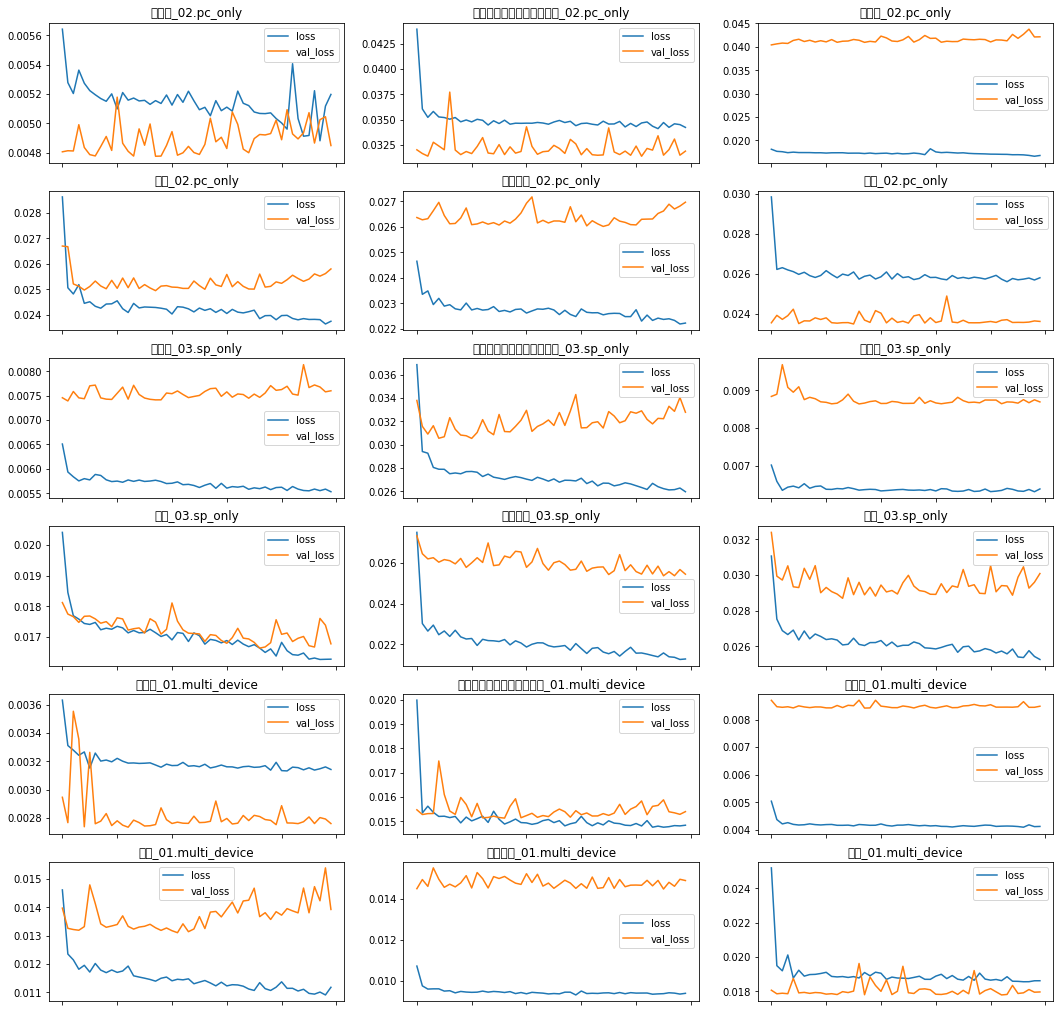

In [32]:
# lossの推移
fig = plt.figure(figsize=(18, 18))
ax_list = []

for i in range(len(category_list)):
    ax_list.append(
        {
            'ax':fig.add_subplot(6, 3, i + 1),
            'category':category_list[i],
            'loss_data':model_list[i].history.history['loss'],
            'val_loss_data':model_list[i].history.history['val_loss']
                }
        )

for ax in ax_list:
    ax['ax'].tick_params(labelbottom='off')
    ax['ax'].set_title(ax['category'])
    ax['ax'].plot(ax['loss_data'], label='loss')
    ax['ax'].plot(ax['val_loss_data'], label='val_loss')
    ax['ax'].legend()

### 次の日の売上を予測


    ゲーム_02.pc_only : 
       - Train 誤差: 0.07069617289952466
       - Test 誤差: 0.06964066984743565
       - 標準偏差: 53321499.11628475 
    


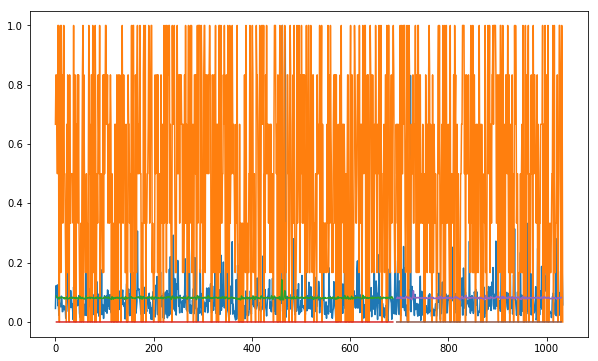


    ライブコミュニケーション_02.pc_only : 
       - Train 誤差: 0.18391599700762443
       - Test 誤差: 0.17858070128145995
       - 標準偏差: 3181434.7749246047 
    


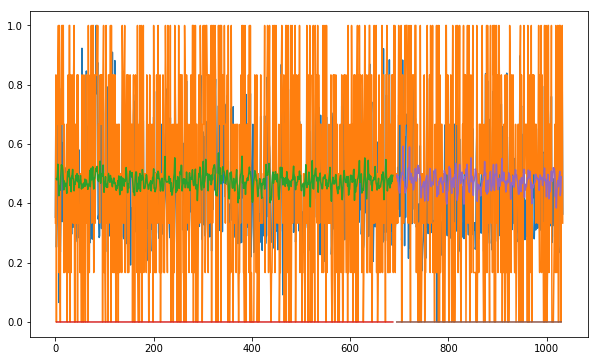


    その他_02.pc_only : 
       - Train 誤差: 0.1273915396846735
       - Test 誤差: 0.205282067148149
       - 標準偏差: 70475613.64465448 
    


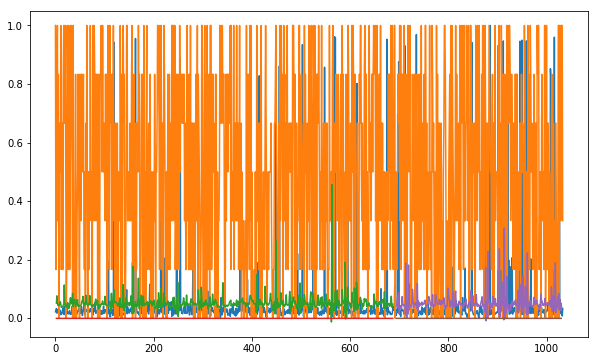


    同人_02.pc_only : 
       - Train 誤差: 0.15317410208456575
       - Test 誤差: 0.16061016133936612
       - 標準偏差: 3900965.832883981 
    


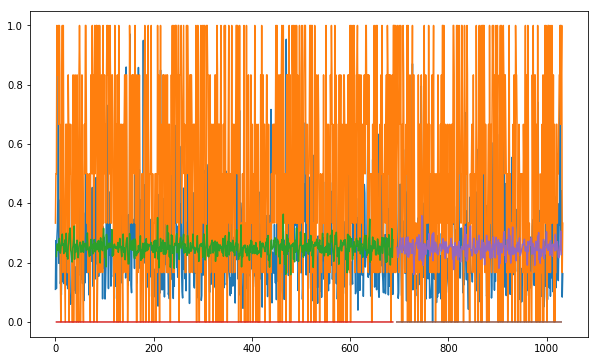


    電子書籍_02.pc_only : 
       - Train 誤差: 0.14703696544651523
       - Test 誤差: 0.16420714833442948
       - 標準偏差: 3990131.0316643356 
    


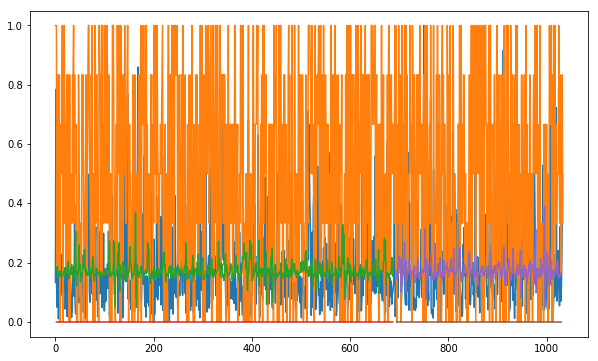


    動画_02.pc_only : 
       - Train 誤差: 0.1598562081649296
       - Test 誤差: 0.15369407253961548
       - 標準偏差: 10511440.340127446 
    


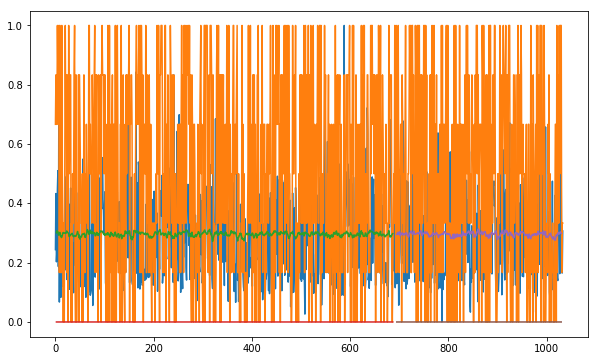


    ゲーム_03.sp_only : 
       - Train 誤差: 0.07467397475905951
       - Test 誤差: 0.08717534410069862
       - 標準偏差: 21603522.010845248 
    


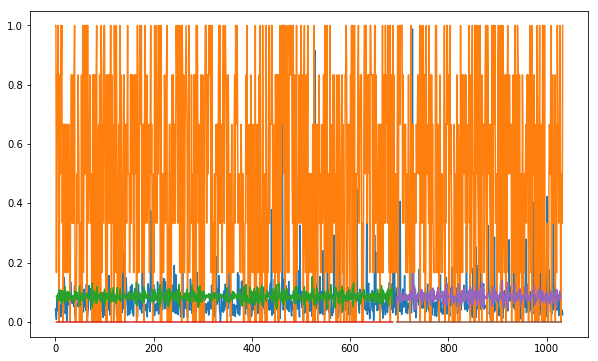


    ライブコミュニケーション_03.sp_only : 
       - Train 誤差: 0.15984261107670963
       - Test 誤差: 0.18106899240615074
       - 標準偏差: 2364669.6635311604 
    


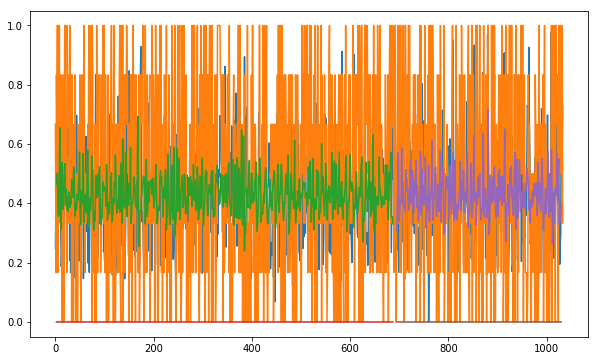


    その他_03.sp_only : 
       - Train 誤差: 0.07910802122716133
       - Test 誤差: 0.09323727543382453
       - 標準偏差: 6826004.089432396 
    


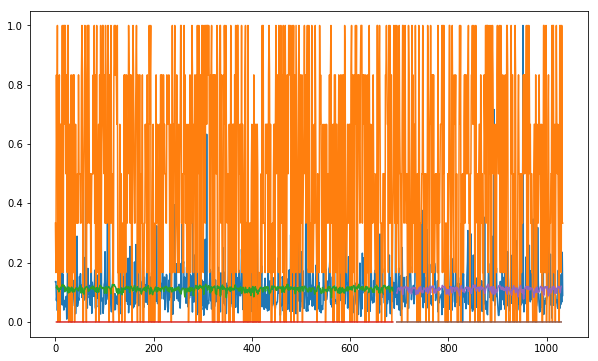


    同人_03.sp_only : 
       - Train 誤差: 0.1257794271703002
       - Test 誤差: 0.12952457835403697
       - 標準偏差: 5644539.402391637 
    


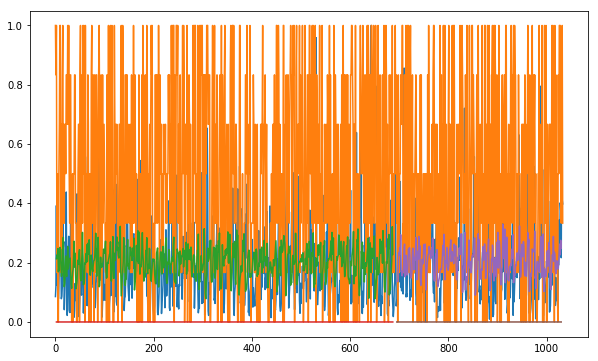


    電子書籍_03.sp_only : 
       - Train 誤差: 0.1451321766656252
       - Test 誤差: 0.15951257739553476
       - 標準偏差: 8768528.651852868 
    


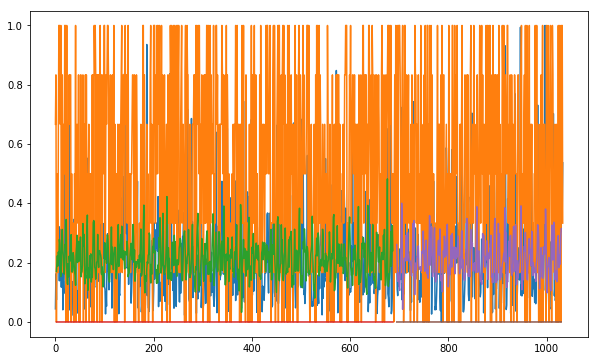


    動画_03.sp_only : 
       - Train 誤差: 0.15837312364239808
       - Test 誤差: 0.17343890678065182
       - 標準偏差: 14895288.58401087 
    


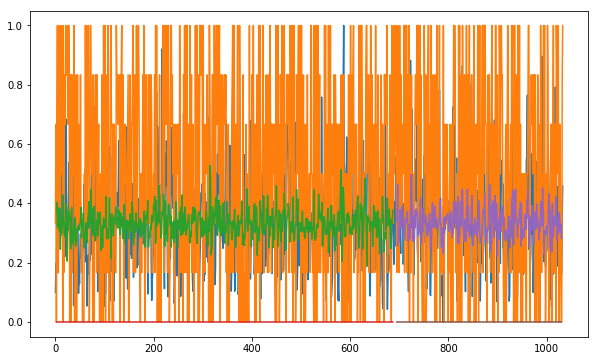


    ゲーム_01.multi_device : 
       - Train 誤差: 0.05579250059247333
       - Test 誤差: 0.052548055436176334
       - 標準偏差: 5243687.198011954 
    


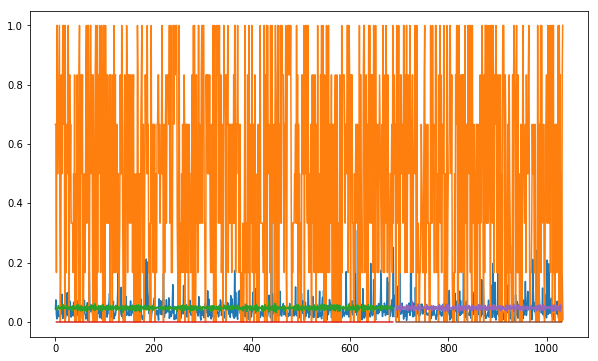


    ライブコミュニケーション_01.multi_device : 
       - Train 誤差: 0.12119953053607925
       - Test 誤差: 0.12408222177131381
       - 標準偏差: 734156.0195522906 
    


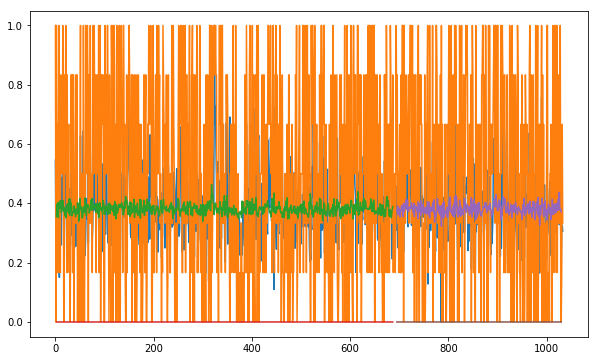


    その他_01.multi_device : 
       - Train 誤差: 0.0639172233901715
       - Test 誤差: 0.09209235962907138
       - 標準偏差: 419053.83291081333 
    


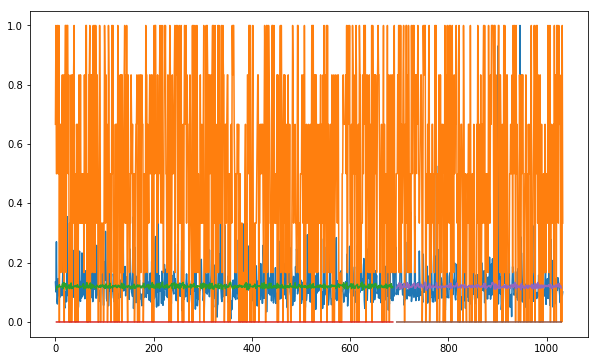


    同人_01.multi_device : 
       - Train 誤差: 0.10322729027646163
       - Test 誤差: 0.11799037557896427
       - 標準偏差: 131672.5634615997 
    


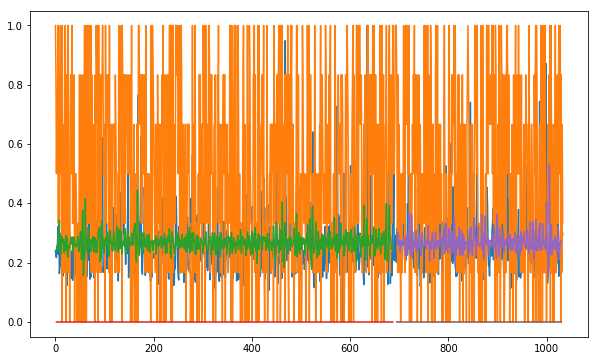


    電子書籍_01.multi_device : 
       - Train 誤差: 0.09650570798569647
       - Test 誤差: 0.12210496765442666
       - 標準偏差: 285913.24108159303 
    


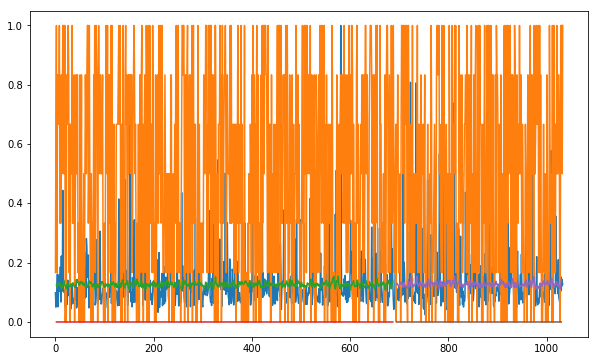


    動画_01.multi_device : 
       - Train 誤差: 0.13498581013340108
       - Test 誤差: 0.13403676053703337
       - 標準偏差: 245484.1179126457 
    


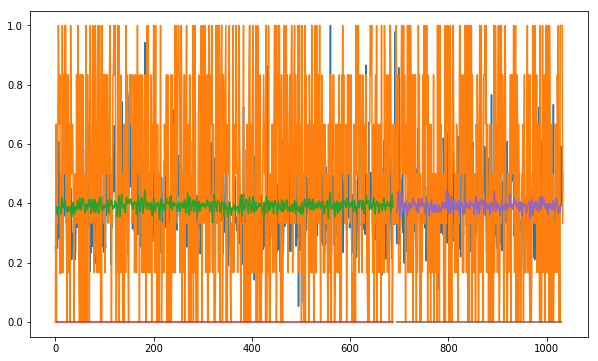

In [31]:
for i in range(len(category_list)):
    print(f'''
    {category_list[i]} : 
       - Train 誤差: {train_score_list[i]}
       - Test 誤差: {test_score_list[i]}
       - 標準偏差: {data_list[i]['nontax_amount'].std()} 
    ''')
    
     # trainの予測データをプロットするために変換
    dataset = scaled_dataset_list[i]
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[train_adjast_num:train_size,:] = rescaled_train_predict_list[i]
    #train_predict_plot[LENGTH_PER_UNIT:len(rescaled_train_predict_list[i])+LENGTH_PER_UNIT, :] = rescaled_train_predict_list[i]

    # testの予測データをプロットするために変換
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[LENGTH_PER_UNIT+train_size:len(dataset)-test_adjast_num,:] = rescaled_test_predict_list[i]
    #test_predict_plot[len(rescaled_train_predict_list[i])+(LENGTH_PER_UNIT*2)+1:len(dataset)-1, :] = rescaled_test_predict_list[i]


    # 予測と元のデータをプロット

    plt.figure(figsize=(10, 6))
    plt.plot(scaler_list[i].inverse_transform(dataset))
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)
    plt.show()

#### まとめ
- 事業×デバイス別に、前営業日の売上額から次営業日の売上額を予測するモデルを作った
- 2016-01-01 ~ 2019-10-31の期間のデータのうち前半2/3を学習データ、後半1/3を検証用データとして用いた
- 評価指標はRMSEを用いた
    - 精度：休日フラグの時とほとんど変わらない
        - 10^-2のオーダー